In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [2]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [4]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


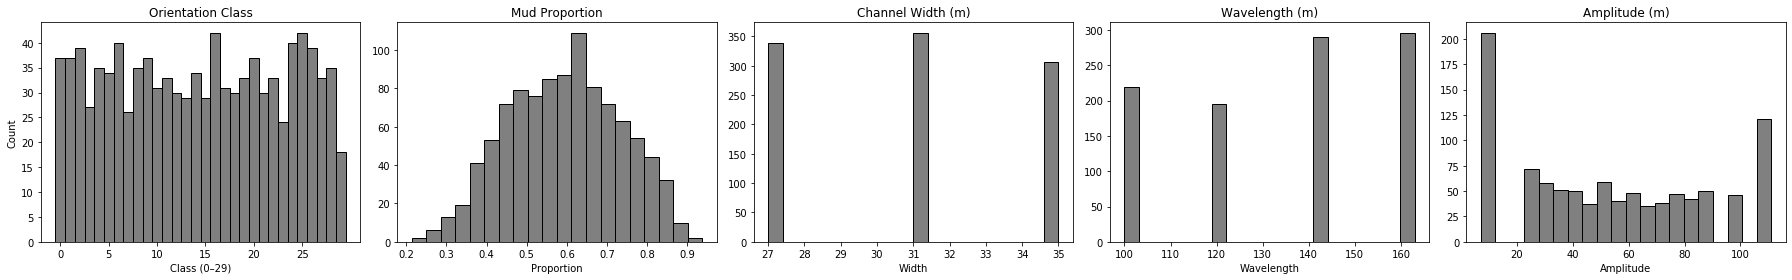

In [5]:
# Create 1-row, 5-column subplot layout
fig, ax = plt.subplots(1, 5, figsize=(25, 4))
plt.subplots_adjust(wspace=0.4)

# Plot orientation class histogram
ax[0].hist(orit_class, bins=np.arange(31)-0.5, color='gray', edgecolor='black')
ax[0].set_title('Orientation Class')
ax[0].set_xlabel('Class (0–29)')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, 30, 5))

# Plot mud proportion histogram
ax[1].hist(mudprop, bins=20, color='gray', edgecolor='black')
ax[1].set_title('Mud Proportion')
ax[1].set_xlabel('Proportion')

# Plot width histogram
ax[2].hist(width, bins=20, color='gray', edgecolor='black')
ax[2].set_title('Channel Width (m)')
ax[2].set_xlabel('Width')

# Plot wavelength histogram
ax[3].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[3].set_title('Wavelength (m)')
ax[3].set_xlabel('Wavelength')

# Plot amplitude histogram
ax[4].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[4].set_title('Amplitude (m)')
ax[4].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()


### 2. Train and load trained unconditional generator and global feature recognizer

In [6]:
generator_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_unc/'
generator_name = 'network-snapshot-025921.pkl' 

recognizer_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FeatureRecognizer/'
recognizer_name = 'network-snapshot-069520.pkl' 

# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import Generator.
    with open(generator_dir+generator_name, 'rb') as file:
        G, _, Gs_unc = pickle.load(file)     
    
    # Import trained global feature recognizer
    with open(recognizer_dir + recognizer_name, 'rb') as file:
        _, R, _ = pickle.load(file)

print(Gs_unc.input_shapes)
print(Gs_unc.output_shapes)

print(R.input_shapes)
print(R.output_shapes)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 8, 4, 4], [None, 0, 4, 4], [None, 0, 64, 64], [None, 0, 64, 64]]
[[None, 3, 64, 64]]
[[None, 1, 64, 64], [None, 0, 64, 64]]
[[None, 1], [None], [None], [None, 34]]


### 3. Evaluate the trained generator by visually comparing test and generated facies models

#### Visualize random test facies models

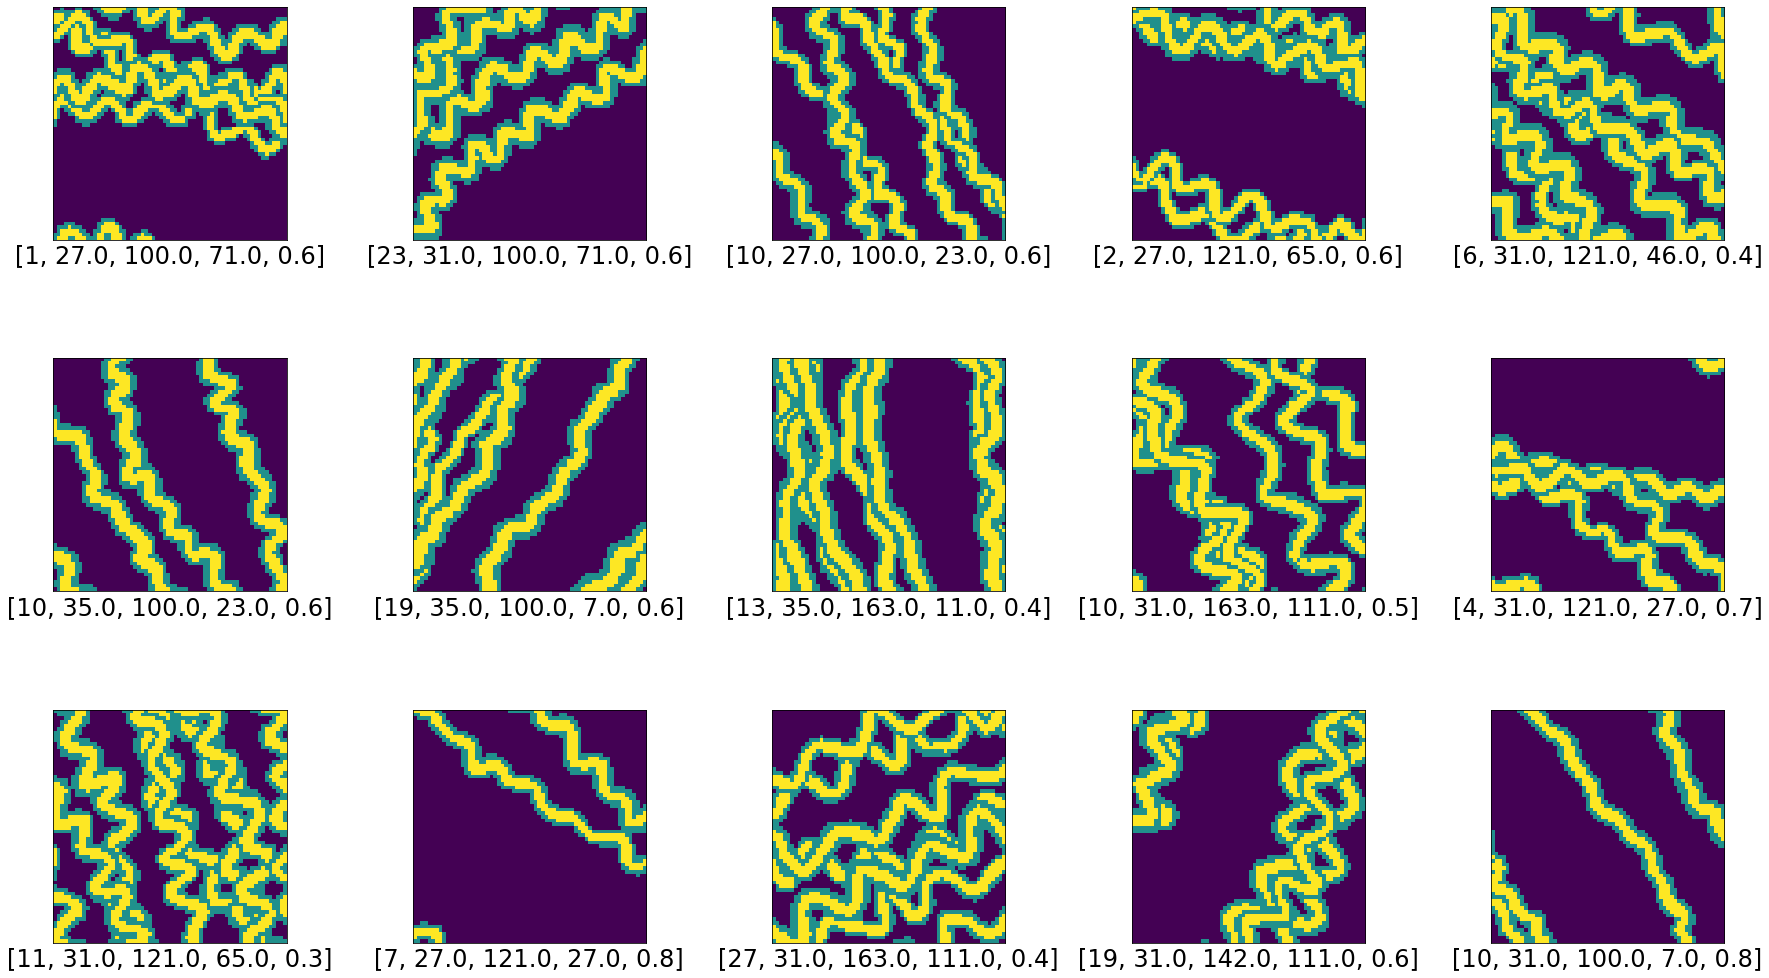

In [7]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for row in range(3):
    for col in range(5):
        idx = row * 5 + col
        ax[row, col].imshow(facies_test[idx, 0].astype(np.float32), cmap='viridis')
        
        # Label format: [Class, Width, Wavelength, Amplitude, MudProp]
        label_text = (
            f"[{orit_class[idx]}, "
            f"{round(width[idx])}, "
            f"{round(wvl[idx])}, "
            f"{round(amplt[idx])}, "
            f"{mudprop[idx]:.1f}]"
        )
        ax[row, col].set_xlabel(label_text)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])

plt.tight_layout()
# plt.savefig("Random_15TestFaciesMaps_ChannelCase.jpg", dpi=200)
plt.show()


Orientation Class Mapping (each class spans 6 degrees):

Class  0: -90 ~ -84
Class  1: -84 ~ -78
Class  2: -78 ~ -72
Class  3: -72 ~ -66
Class  4: -66 ~ -60
Class  5: -60 ~ -54
Class  6: -54 ~ -48
Class  7: -48 ~ -42
Class  8: -42 ~ -36
Class  9: -36 ~ -30
Class 10: -30 ~ -24
Class 11: -24 ~ -18
Class 12: -18 ~ -12
Class 13: -12 ~  -6
Class 14:  -6 ~   0
Class 15:   0 ~   6
Class 16:   6 ~  12
Class 17:  12 ~  18
Class 18:  18 ~  24
Class 19:  24 ~  30
Class 20:  30 ~  36
Class 21:  36 ~  42
Class 22:  42 ~  48
Class 23:  48 ~  54
Class 24:  54 ~  60
Class 25:  60 ~  66
Class 26:  66 ~  72
Class 27:  72 ~  78
Class 28:  78 ~  84
Class 29:  84 ~  90

#### Randomly generate using the trained unconditional generator and visualize facies models

In [8]:
# randomly generate 1000 facies models from the unconditional generator

TotalModel_no = 1000
fakemodel_indicators = np.zeros([TotalModel_no, 4, 64, 64])
latents = np.random.RandomState(41).randn(TotalModel_no, 8, 4, 4)
labels = np.zeros((TotalModel_no, 0, 4, 4))
wellfacies = np.zeros((TotalModel_no, 0, 64, 64)) 
prob = np.zeros((TotalModel_no, 0, 64, 64)) 
fakemodel_indicators = Gs_unc.run(latents, labels, wellfacies, prob) # facies indicator models for the four facies types
   
print(fakemodel_indicators.shape)

fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1) # argmax function to obtain facies models
print(fakemodels.shape)

(1000, 3, 64, 64)
(1000, 1, 64, 64)


In [9]:
# calculate the global features for the 1000 generated facies models based on the trained recognizer neural network

labels_gan_R = R.run(fakemodels, wellfacies)[-1]
    
orit_one_hot_gan_R = labels_gan_R[:, :30]
orit_class_gan_R = np.argmax(orit_one_hot_gan_R, axis = 1)  #

mudprop_gan_R = labels_gan_R[:, 30] 
mudprop_gan_R = (mudprop_gan_R / 2 + 0.5) * 0.8037 + 0.1677

wid_gan_R = labels_gan_R[:, 31]  # width after normalization
wid_gan_R = np.where(wid_gan_R < -0.5, -1, np.where(wid_gan_R > 0.5, 1, 0)) 
wid_gan_R = (wid_gan_R / 2 + 0.5) * 8 + 27

wvl_gan_R = labels_gan_R[:, 32]  # width after normalization
wvl_gan_R = np.where(wvl_gan_R < -0.5, -1, np.where(wvl_gan_R < 0., -0.33, np.where(wvl_gan_R > 0.5, 1, 0.3))) 
wvl_gan_R = np.round((wvl_gan_R / 2 + 0.5) * 63 + 100)

amplt_gan_R = labels_gan_R[:, 33] 
amplt_gan_R = (amplt_gan_R / 2 + 0.5) * 104 + 7


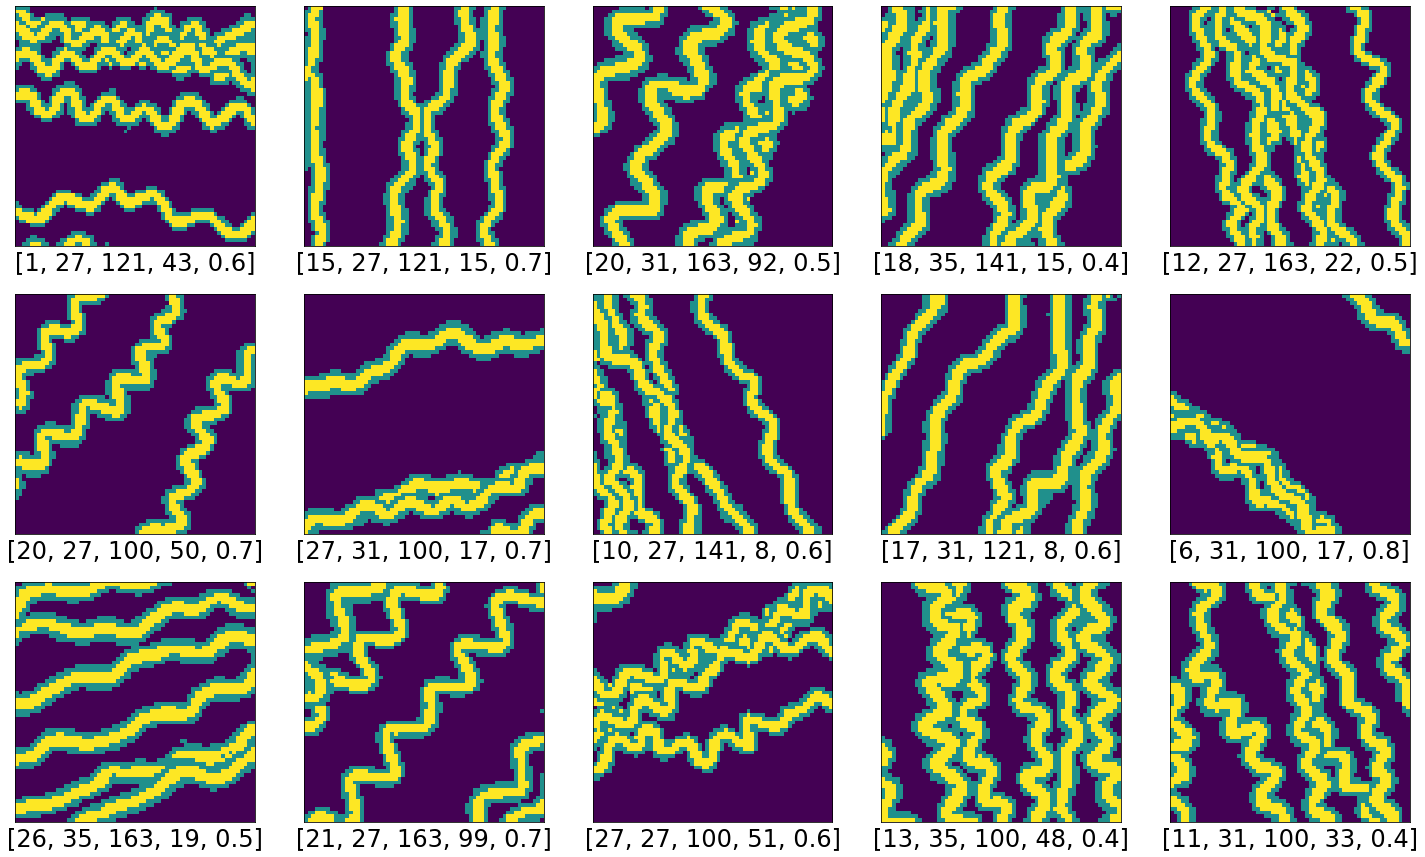

In [11]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

def feature_str(idx):
    return f'[{orit_class_gan_R[idx]}, {wid_gan_R[idx]:.0f}, {wvl_gan_R[idx]:.0f}, {amplt_gan_R[idx]:.0f}, {mudprop_gan_R[idx]:.1f}]'

for j in range(5):
    ax[0, j].imshow(fakemodels[j, 0].astype(np.float32))
    ax[0, j].set_xlabel(feature_str(j))
    ax[0, j].set_yticks([])

for j in range(5):
    ax[1, j].imshow(fakemodels[j+10, 0].astype(np.float32))
    ax[1, j].set_xlabel(feature_str(j+10))
    ax[1, j].set_yticks([])

for j in range(5):
    ax[2, j].imshow(fakemodels[j+15, 0].astype(np.float32))
    ax[2, j].set_xlabel(feature_str(j+15))
    ax[2, j].set_xticks([])
    ax[2, j].set_yticks([])

# plt.savefig(mcmc_dir + "Random_15_GeneratedFaciesMaps_Features.jpg", dpi=200)


### 4. Quantitatively evaluate the unconditional generator

##### 4.1 Facies proportion histograms

In [12]:
fakemodels_bk_prop = np.mean(np.where(fakemodels == 1, 1, 0), axis = (1, 2, 3)) # bank
fakemodels_ch_prop = np.mean(np.where(fakemodels == 2, 1, 0), axis = (1, 2, 3)) # channel center deposit
fakemodels_md_prop = 1 - fakemodels_bk_prop - fakemodels_ch_prop  # background mud

realimgs_test_bk_prop = np.mean(np.where(facies_test == 1, 1, 0), axis = (1, 2, 3)) # 
realimgs_test_ch_prop = np.mean(np.where(facies_test == 2, 1, 0), axis = (1, 2, 3)) # 
realimgs_test_md_prop = 1 - realimgs_test_bk_prop - realimgs_test_ch_prop  

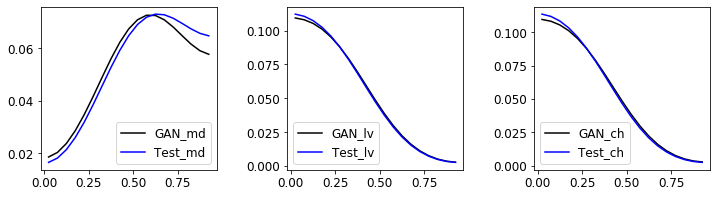

In [13]:
import scipy

bins_md=np.arange(0.0,1.,0.05)
counts_fake_md, bin_edges_md = np.histogram(fakemodels_md_prop, bins=bins_md)
counts_fake_md = counts_fake_md / 1000.
fakemodels_md_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_md, sigma=5)
counts_real_md, bin_edges_md = np.histogram(realimgs_test_md_prop, bins=bins_md)
counts_real_md = counts_real_md / 1000.
realimgs_test_md_prop_sm = scipy.ndimage.gaussian_filter(counts_real_md, sigma=5)

bins_bk=np.arange(0.0,1.,0.05)
counts_fake_bk, bin_edges_bk = np.histogram(fakemodels_bk_prop, bins=bins_bk)
counts_fake_bk = counts_fake_bk / 1000.
fakemodels_bk_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_bk, sigma=5)
counts_real_bk, bin_edges_bk = np.histogram(realimgs_test_bk_prop, bins=bins_bk)
counts_real_bk = counts_real_bk / 1000.
realimgs_test_bk_prop_sm = scipy.ndimage.gaussian_filter(counts_real_bk, sigma=5)

bins_ch=np.arange(0.0,1.,0.05)
counts_fake_ch, bin_edges_ch = np.histogram(fakemodels_ch_prop, bins=bins_ch)
counts_fake_ch = counts_fake_ch / 1000.
fakemodels_ch_prop_sm = scipy.ndimage.gaussian_filter(counts_fake_ch, sigma=5)
counts_real_ch, bin_edges_ch = np.histogram(realimgs_test_ch_prop, bins=bins_ch)
counts_real_ch = counts_real_ch / 1000.
realimgs_test_ch_prop_sm = scipy.ndimage.gaussian_filter(counts_real_ch, sigma=5)


plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(12, 3, forward=True)

axes[0].plot((bin_edges_md[1:] + bin_edges_md[:-1])/2, fakemodels_md_prop_sm, color='k', label = 'GAN_md')
axes[0].plot((bin_edges_md[1:] + bin_edges_md[:-1])/2, realimgs_test_md_prop_sm, color='blue', label = 'Test_md')
axes[1].plot((bin_edges_bk[1:] + bin_edges_bk[:-1])/2, fakemodels_bk_prop_sm, color='k', label = 'GAN_lv')
axes[1].plot((bin_edges_bk[1:] + bin_edges_bk[:-1])/2, realimgs_test_bk_prop_sm, color='blue', label = 'Test_lv')
axes[2].plot((bin_edges_ch[1:] + bin_edges_ch[:-1])/2, fakemodels_ch_prop_sm, color='k', label = 'GAN_ch')
axes[2].plot((bin_edges_ch[1:] + bin_edges_ch[:-1])/2, realimgs_test_ch_prop_sm, color='blue', label = 'Test_ch')


plt.rcParams.update({'font.size': 12})
axes[0].legend(loc='lower right') 
axes[1].legend(loc='lower left') 
axes[2].legend(loc='lower left')

plt.subplots_adjust(wspace=0.4)  # Increase this value for more space

# plt.savefig(generator_dir + "Facies proportion histogram comparison.jpg", dpi=200)   
    

##### 4.2 Global feature histograms

In [14]:
# calculate the global features for the 1000 test facies models based on the trained recognizer neural network

labels_real_R = R.run(facies_test, wellfacies)[-1]
    
orit_one_hot_real_R = labels_real_R[:, :30]
orit_class_real_R = np.argmax(orit_one_hot_real_R, axis = 1)  #

mudprop_real_R = labels_real_R[:, 30] 
mudprop_real_R = (mudprop_real_R / 2 + 0.5) * 0.8037 + 0.1677

wid_real_R = labels_real_R[:, 31]  # width after normalization
wid_real_R = np.where(wid_real_R < -0.5, -1, np.where(wid_real_R > 0.5, 1, 0)) 
wid_real_R = (wid_real_R / 2 + 0.5) * 8 + 27

wvl_real_R = labels_real_R[:, 32]  # width after normalization
wvl_real_R = np.where(wvl_real_R < -0.5, -1, np.where(wvl_real_R < 0., -0.33, np.where(wvl_real_R > 0.5, 1, 0.3))) 
wvl_real_R = np.round((wvl_real_R / 2 + 0.5) * 63 + 100)

amplt_real_R = labels_real_R[:, 33] 
amplt_real_R = (amplt_real_R / 2 + 0.5) * 104 + 7

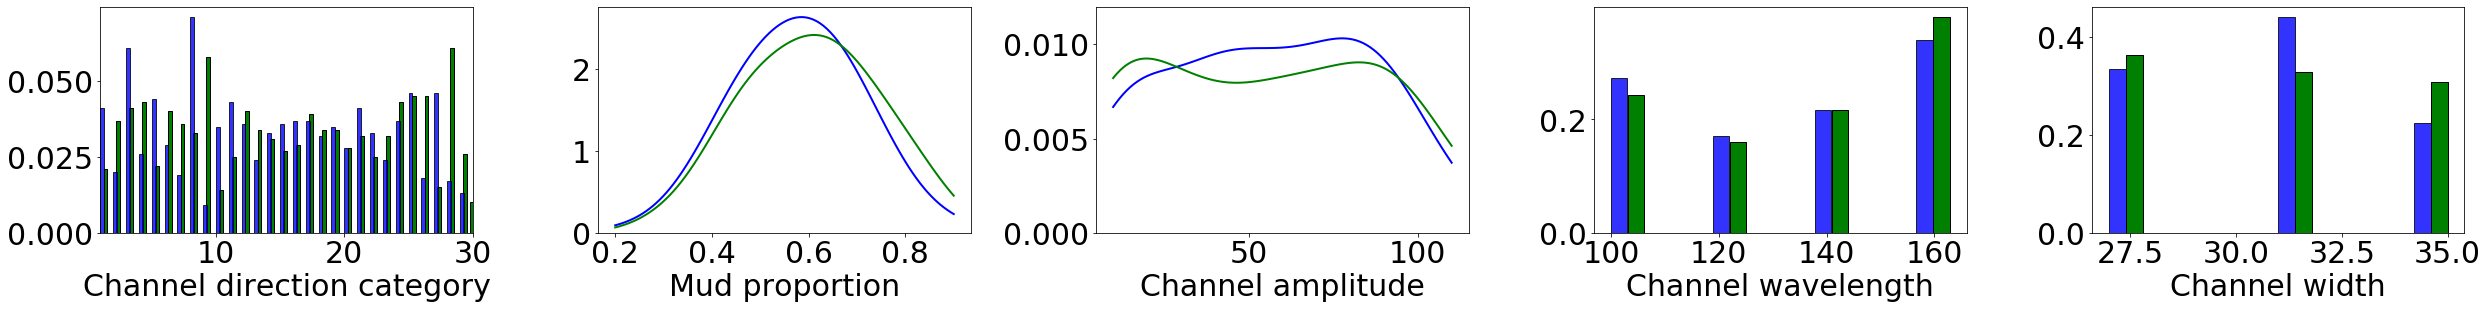

In [15]:
plt.rcParams.update({'font.size': 30})

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(35, 5)

# Plot the histograms for orit_class_gan_R, orit_class_mcmc_R, and orit_class
barwidth = 0.3  # Width for each bar
bin_edges = np.arange(1, 30.5, 0.5)
arr = (orit_class_real_R+1)
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = orit_class_gan_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[0].set_xlim(left=1, right = 30)
ax[0].set_xlabel('Channel direction category')

from scipy.stats import gaussian_kde
x_range = np.linspace(0.2, 0.9, 100)  # Generate range of values for x-axis
kde_gan = gaussian_kde(mudprop_gan_R, bw_method=0.5)
pdf_values_gan = kde_gan(x_range)  # Compute PDF values for the range
kde = gaussian_kde(mudprop_real_R, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values_gan, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_gan_R
#ax[1].plot(x_range, pdf_values_mcmc_R, 'orange', linewidth=2, label='mcmc PDF')  # Plot PDF for mudprop_mcmc_R
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')  # Plot PDF for mudprop
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Mud proportion')

x_range = np.linspace(10, 110, 100)  # Generate range of values for x-axis
kde_gan_R = gaussian_kde(amplt_gan_R, bw_method=0.35)
pdf_values_gan_R = kde_gan_R(x_range)  # Compute PDF values for the range
kde = gaussian_kde(amplt_real_R, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[2].plot(x_range, pdf_values_gan_R, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_gan_R
ax[2].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')  # Plot PDF for mudprop
ax[2].set_ylim(bottom=0, top = 0.012)
ax[2].set_xlabel('Channel amplitude')

barwidth = 3  # Width for each bar
bin_edges = [100. , 106.3, 112.6, 118.9, 125.2, 131.5, 137.8, 144.1, 150.4, 156.7, 163. ]
arr = wvl_real_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wvl_gan_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[3].set_xlabel('Channel wavelength')

# Plot the histograms for wid_gan_R, wid_mcmc_R, and width
bin_edges = [27. , 27.8, 28.6, 29.4, 30.2, 31. , 31.8, 32.6, 33.4, 34.2, 35. ]
barwidth = 0.4
arr = wid_real_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wid_gan_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[4].set_xlabel('Channel width')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.1)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(generator_dir + "GlobalFeatures_histograms.jpg", dpi=100)


##### 4.3 MDS plots

###### MDS plot based on Sliced Wasserstein Distance (SWD) calculated from multiscale pyramids

In [16]:
from scipy import signal
from scipy.ndimage.filters import convolve
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import kde
import scipy.ndimage

gaussian_filter = np.float32([
    [1, 4,  6,  4,  1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4,  6,  4,  1]]) / 256.0

def pyr_down(minibatch): # matches cv2.pyrDown()
    assert minibatch.ndim == 4
    return scipy.ndimage.convolve(minibatch, gaussian_filter[np.newaxis, np.newaxis, :, :], mode='mirror')[:, :, ::2, ::2]

def pyr_up(minibatch): # matches cv2.pyrUp()
    assert minibatch.ndim == 4
    S = minibatch.shape
    res = np.zeros((S[0], S[1], S[2] * 2, S[3] * 2), minibatch.dtype)
    res[:, :, ::2, ::2] = minibatch
    return scipy.ndimage.convolve(res, gaussian_filter[np.newaxis, np.newaxis, :, :] * 4.0, mode='mirror')

def generate_laplacian_pyramid(minibatch, num_levels):
    pyramid = [np.float32(minibatch)]
    for i in range(1, num_levels):
        pyramid.append(pyr_down(pyramid[-1]))
        pyramid[-2] -= pyr_up(pyramid[-1])
    return pyramid

def get_descriptors_for_minibatch(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, channel, height, width)
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, chan, x, y = np.ogrid[0:N, 0:1, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[3] - H, size=(N, 1, 1, 1))
    y = y + np.random.randint(H, S[2] - H, size=(N, 1, 1, 1))
    idx = ((img * S[1] + chan) * S[2] + y) * S[3] + x
    return minibatch.flat[idx]

# Only extract descriptors at values > 0.3 
def get_descriptors_for_minibatch_indc(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, channel, height, width)
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2

    minibatch_ = np.zeros(minibatch.shape)
    minibatch_[:,:, H : S[2] - H, H : S[3] - H] = minibatch[:,:, H : S[2] - H, H : S[3] - H]
    one_coos = np.argwhere(minibatch_>=0.2)
    center_index = np.random.randint(0, one_coos.shape[0], N)    
    center_coos = one_coos[center_index]
    desc = np.zeros((N, 1, nhood_size, nhood_size))
    for i in range(N):
        desc[i] = minibatch[center_coos[i, 0], 0, center_coos[i, 2] - H: center_coos[i, 2] + H + 1, center_coos[i, 3] - H: center_coos[i, 3] + H + 1]
    return desc

def finalize_descriptors(desc):
    if isinstance(desc, list):
        desc = np.concatenate(desc, axis=0)
    assert desc.ndim == 4 # (neighborhood, channel, height, width)
    desc -= np.mean(desc, axis=(0, 2, 3), keepdims=True)
    desc /= np.std(desc, axis=(0, 2, 3), keepdims=True)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def sliced_wasserstein(A, B, dir_repeats, dirs_per_repeat):
    assert A.ndim == 2 and A.shape == B.shape                           # (neighborhood, descriptor_component)
    results = []
    for repeat in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)             # (descriptor_component, direction)
        dirs /= np.sqrt(np.sum(np.square(dirs), axis=0, keepdims=True)) # normalize descriptor components for each direction
        dirs = dirs.astype(np.float32)
        projA = np.matmul(A, dirs)                                      # (neighborhood, direction)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)                                  # sort neighborhood projections for each direction
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)                                   # pointwise wasserstein distances
        results.append(np.mean(dists))                                  # average over neighborhoods and directions
    return np.mean(results)                                             # average over repeats


In [17]:
def indicatorize(facies_img, codes):
    s = facies_img.shape
    ind_imgs = np.zeros((s[0], 0, s[2], s[3]), np.float32)
    for code in codes:
        ind_imgs = np.concatenate([ind_imgs, np.where(facies_img == code, 1, 0)], axis = 1)
    return ind_imgs

def convert_to_matrix(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    np.transpose(out)[mask] = a        
    return out 

In [18]:
def plot_samples(axis, swd_matrix):
    mds = manifold.MDS(n_components=2, max_iter=6000, eps=1e-19, dissimilarity="precomputed", n_jobs=1)
    coos = mds.fit(swd_matrix).embedding_
            
    x_test_co = coos[:mds_grps, 0]
    y_test_co = coos[:mds_grps, 1]
    x_produced_co = coos[mds_grps:mds_grps+mds_grps, 0]
    y_produced_co = coos[mds_grps:mds_grps+mds_grps, 1]  
            
    plot_lim_min = -0.4
    plot_lim_max = 0.4

    ax_left = axis.inset_axes([0., 0., 0.47, 1])
    ax_right = axis.inset_axes([0.53, 0., 0.47, 1])
    
    ax_left.set(xticks=[-0.5, 0, 0.5], yticks=[-0.6, -0.3, 0, 0.3, 0.6])  # remove the tick lab    
    ax_right.tick_params(left=False)  # remove the ticks
    ax_right.set(xticks=[-0.5, 0, 0.5], yticklabels=[])  # remove the tick lab
    
    #ax_left.set_title('Scatterplot')
    ax_left.set_xlim([plot_lim_min, plot_lim_max])
    ax_left.set_ylim([plot_lim_min, plot_lim_max])        
    ax_left.plot(x_test_co, y_test_co, 'ro', label = 'Test')
    ax_left.plot(x_produced_co, y_produced_co, 'b+', label = 'Generated')
    ax_left.legend(loc='upper right')
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 40
    k_test = kde.gaussian_kde((coos.T[:, :mds_grps]))
    xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
    zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
    ax_right.set_xlim([plot_lim_min, plot_lim_max])
    ax_right.set_ylim([plot_lim_min, plot_lim_max])                
    test_contr = ax_right.contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='r', label = 'Test') 
    
    k_produced = kde.gaussian_kde((coos.T[:, mds_grps:mds_grps+mds_grps]))
    xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
    zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
    produced_contr = ax_right.contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated') 
            
    test_contr.collections[0].set_label('Test')
    produced_contr.collections[0].set_label('Generated')
            
    #ax_right.set_title('Densityplot')
    ax_right.legend(loc='upper right') 

In [19]:
test_mds_num = 90  # total number
prod_mds_num = 90
mds_grps = 30  # groups, each group contain multiple facies models, each group corresponds to one point
num_per_grp = int(test_mds_num / mds_grps)
codes = [0, 1, 2]
codes_swd_w = [1/3., 1/3., 1/3.]
nhood_sizes = [5, 5, 5]    # neighborhood size, 5x5x5
nhoods_per_image   = 24
dir_repeats        = 4
dirs_per_repeat    = 64
resolutions = [64, 32, 16]  # pyramid resolutions

In [20]:
test_indicators_mds = indicatorize(facies_test[0:0+test_mds_num], codes) # np.tile(indicatorize(facies_test[0:0+2], codes), (int(prod_mds_num/2), 1, 1, 1, 1)) # 
prod_indicators_mds = fakemodel_indicators[0:0+prod_mds_num]
all_indicators_mds = np.squeeze(np.concatenate((test_indicators_mds, prod_indicators_mds), axis = 0))  # shape [251, 64, 64, 64]
#all_indicators_mds = np.expand_dims(all_indicators_mds, axis = 1)

kk = np.tril(np.ones((mds_grps * 2, mds_grps * 2)), -1)  
coor = np.argwhere(kk > 0)
list_1 = coor[:, 0]
list_2 = coor[:, 1] 

swd_matrix_list_64 = []  # swd_matrix for different codes
swd_matrix_list_32 = []  # swd_matrix for different codes
swd_matrix_list_16 = []  # swd_matrix for different codes

for j in range(len(codes)):
    groups_lap = []
    for i in range(mds_grps * 2):
        descriptors = [[] for res in resolutions]
        m = 0
        for lod, level in enumerate(generate_laplacian_pyramid(all_indicators_mds[i * num_per_grp : (i+1) * num_per_grp, j:j+1], len(resolutions))):
            desc = get_descriptors_for_minibatch(level, nhood_sizes[m], nhoods_per_image)
            descriptors[lod].append(desc)
            m = m + 1
        groups_lap.append(descriptors)

    gr_swd_64 = []
    gr_swd_32 = []
    gr_swd_16 = []
    for gr in range(list_1.shape[0]):
        desc_1 = [finalize_descriptors(d) for d in groups_lap[list_1[gr]]]
        desc_2 = [finalize_descriptors(d) for d in groups_lap[list_2[gr]]]
        slw = [sliced_wasserstein(dreal, dfake, dir_repeats, dirs_per_repeat) for dreal, dfake in zip(desc_1, desc_2)]

        gr_swd_64.append(slw[0]) #np.mean(slw))
        gr_swd_32.append(slw[1]) #np.mean(slw))
        gr_swd_16.append(slw[2]) #np.mean(slw))
 
    swd_matrix_list_64.append(convert_to_matrix(gr_swd_64))
    swd_matrix_list_32.append(convert_to_matrix(gr_swd_32))
    swd_matrix_list_16.append(convert_to_matrix(gr_swd_16))

In [21]:
swd_matrix_list_mean_code0 = (swd_matrix_list_64[0] + swd_matrix_list_32[0] + swd_matrix_list_16[0])/3
swd_matrix_list_mean_code1 = (swd_matrix_list_64[1] + swd_matrix_list_32[1] + swd_matrix_list_16[1])/3
swd_matrix_list_mean_code2 = (swd_matrix_list_64[2] + swd_matrix_list_32[2] + swd_matrix_list_16[2])/3

swd_matrix_list_64_mean = (swd_matrix_list_64[0] + swd_matrix_list_64[1] + swd_matrix_list_64[2])/3 
swd_matrix_list_32_mean = (swd_matrix_list_32[0] + swd_matrix_list_32[1] + swd_matrix_list_32[2])/3 
swd_matrix_list_16_mean = (swd_matrix_list_16[0] + swd_matrix_list_16[1] + swd_matrix_list_16[2])/3 

swd_matrix_mean = (swd_matrix_list_mean_code0 + swd_matrix_list_mean_code1 + swd_matrix_list_mean_code2) / 3

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: The following kwargs were not used by contour: 'label'
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'label'


(0.0, 1.0, 0.0, 1.0)

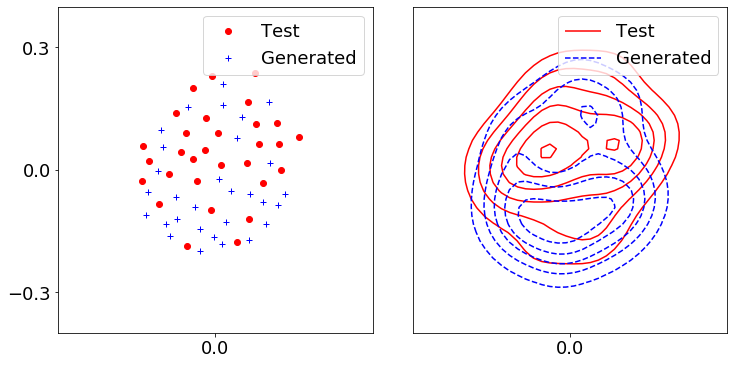

In [22]:
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(ncols=1, nrows=1, sharex='col', sharey='row')
fig.set_size_inches(12, 6, forward=True)
fig.subplots_adjust(wspace=0.1, hspace=0.2)

plot_samples(axes, swd_matrix_mean)

axes.axis('off') 

# Save the figure
#plt.savefig(generator_dir + "MDS plots.jpg", dpi=100)


### 5. Post-GANs (MCMC) for conditioning to given global features


**Assume the channel direction corresponds to class 22 (42 to 48 degrees) The channel width, amplitude, and wavelength are 31 m, 55 m, and 121 m, respectively. The mud proportion of the reservoir is 0.65. **

#### 5.1. MCMC execution

In [23]:
from scipy.stats import multivariate_normal

labels_run = np.zeros((1, 0, 4, 4))
wellfacies_run = np.zeros((1, 0, 64, 64)) 
prob_run = np.zeros((1, 0, 64, 64)) 

def cal_lik_from_z(z):
    sigma_e = 0.1
    
    fakemodel_indicators = Gs_unc.run(z, labels_run, wellfacies_run, prob_run)
    fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)  # [N, 1, 64, 64]
    
    labels_NN = R.run(fakemodels, wellfacies_run)[-1]
    
    orit_one_hot_NN = labels_NN[0, :30]
    orit_class_NN = np.argmax(orit_one_hot_NN)  #
    
    mudprop_NN = labels_NN[0, 30] 
    mudprop_NN = (mudprop_NN / 2 + 0.5) * 0.8037 + 0.1677
 
    wid_NN = labels_NN[0, 31] # width after normalization
    wid_NN = np.where(wid_NN <-0.5, -1, np.where(wid_NN > 0.5, 1, 0)) 
    wid_NN = (wid_NN / 2 + 0.5) * 8 + 27
 
    wvl_NN = labels_NN[0, 32] # width after normalization
    wvl_NN = np.where(wvl_NN <-0.5, -1, np.where(wvl_NN < 0, -0.333, np.where(wvl_NN > 0.5, 1., 0.333))) 
    wvl_NN = np.round((wvl_NN / 2 + 0.5) * 63 + 100)

    amplt_NN = labels_NN[0, 33] 
    amplt_NN = (amplt_NN / 2 + 0.5) * 104 + 7
    
    dist = (6*(orit_class_NN - 22) / 30)**2 + (3*(mudprop_NN - 0.65)/0.7)**2 + ((wid_NN - 31)/8)**2\
    + ((wvl_NN - 121)/63)**2 + (3*(amplt_NN - 55)/104)**2 

    likelihood = 1 / (sigma_e * (2 * np.pi) ** 0.5) * np.exp(-0.5*(dist/sigma_e)**2)
    # - points_num / 2 * np.log(2 * np.pi) - points_num * np.log(sigma_e) - 0.5 * sigma_e**(-2) * dist  # log norm
    
    return likelihood, dist

def cal_prior(z):
    dim = np.prod(z.shape[1:])
    m = np.zeros(dim,)
    C = np.eye(dim)
    prior = multivariate_normal.pdf(z.reshape(-1),mean=m,cov=C)    
    return prior

import time
def latent_selection_mcmc(opt_max_num):  # , dist_thresh
    time_st = time.time()
    new_z_sigma = 0.06
    z_dim = [1] + Gs.input_shapes[0][1:]
       
    latents = []
    dists = []
    times = []
       
    latent = np.random.randn(*z_dim) 
    likelihood, dist = cal_lik_from_z(latent)
    prior = cal_prior(latent)
    opt_num = 0
    while opt_num < opt_max_num: 
        
        latent_new = latent + np.random.normal(0, new_z_sigma, size=z_dim)
        likelihood_new, dist_new = cal_lik_from_z(latent_new)
        prior_new = cal_prior(latent_new)
        
        rho = min(1, likelihood_new / likelihood * (prior_new / prior))
        
        u = np.random.uniform()
        if u < rho:
            latent = latent_new
            likelihood = likelihood_new
            dist = dist_new
            prior = prior_new           
           # if dist < dist_thresh:   
            latents.append(latent)
            dists.append(dist)
            time_ed = time.time()
            times.append(time_ed - time_st) 
            time_st = time.time()
                    
        opt_num = opt_num + 1  
    
    return latents, dists, times

In [56]:
chain_no = 10  # MCMC chain number  5
opt_max_num = 50000  # 200000
# dist_thresh = 0.2  # 0.12

latents_mul_chain = []
dists_mul_chain = []
times_mul_chain = []
chain_count = []

time_mcmc_st = time.time()
for i in range(chain_no):  
    print(i)
    latents, dists, times = latent_selection_mcmc(opt_max_num)
    latents_mul_chain = latents_mul_chain + latents 
    dists_mul_chain = dists_mul_chain + dists
    times_mul_chain = times_mul_chain + times
    latents_no = len(dists)
    chain_count = chain_count + ([i + 1] * latents_no)
time_mcmc_ed = time.time()
time_mcmc_whole = time_mcmc_ed - time_mcmc_st
print(time_mcmc_whole)

total_latent_no = len(dists_mul_chain)
converg_info = np.zeros((total_latent_no, 131))
converg_info[:,0] = np.array(chain_count)
converg_info[:,1] = np.array(times_mul_chain)
converg_info[:,2] = np.array(dists_mul_chain)
converg_info[:,3:] = np.array(latents_mul_chain)[:,0,:].reshape(-1, 128)
    
mcmc_convg_info_fname = "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MCMCForGlobalFeatureConditioning/MCMC_Fluvial_10chainx50kiter_sig_p1.txt"
np.savetxt(mcmc_convg_info_fname, converg_info, fmt= '%i ' + '%4.3f ' + '%3.3f '  + "%1.8f " * 128, newline='\n')  

0


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars


1
2
3
4
5


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


6
7
8
9
21.41404414176941


#### 5.2. Evaluation of MCMC results

*Import accepted latent vectors obtained from MCMC*

In [24]:
mcmc_dir = "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MCMCForGlobalFeatureConditioning/"
mcmc_convg_info_fname =  mcmc_dir + "MCMC_Fluvial_10chainx50kiter_sig_p1.txt"

allele=[] 
with open(mcmc_convg_info_fname, 'r') as f:
    for line in f:
        eles = line.strip().split(' ')
        allele.append(eles)

converg_info = np.array(allele, dtype = float).reshape((-1, 131))
print(converg_info.shape)

(61803, 131)


In [25]:
converg_chains = converg_info[:, 0]
converg_times = converg_info[:, 1]
converg_dists = converg_info[:, 2]
converg_latents = converg_info[:,3:].reshape(-1, 8, 4, 4)

print(converg_latents.shape)
print(np.average(converg_dists))
print(np.average(converg_times))

(61803, 8, 4, 4)
0.3060103231234729
0.0754995064964484


*Only choose samples with convergence distances smaller than 0.2*

In [26]:
all_chain_dist_ord = np.argwhere(converg_dists<0.2)[:, 0]
converg_dists_all_chains = converg_dists[all_chain_dist_ord]
converg_latents_all_chains = converg_latents[all_chain_dist_ord]#converg_latents[all_chain_dist_ord[:2000]]
print(converg_latents_all_chains.shape)

(45673, 8, 4, 4)


*Randomly sample 200 samples from these accepted samples.*

(200, 8, 4, 4)


(array([ 2.,  1.,  7.,  5.,  6.,  6.,  9.,  8.,  7.,  5., 10.,  7.,  2.,
         8., 13., 12.,  2.,  8.,  7.,  9., 17., 13., 13., 13., 10.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.   , 0.008, 0.016, 0.024, 0.032, 0.04 , 0.048, 0.056, 0.064,
        0.072, 0.08 , 0.088, 0.096, 0.104, 0.112, 0.12 , 0.128, 0.136,
        0.144, 0.152, 0.16 , 0.168, 0.176, 0.184, 0.192, 0.2  , 0.208,
        0.216, 0.224, 0.232, 0.24 , 0.248, 0.256, 0.264, 0.272, 0.28 ,
        0.288, 0.296, 0.304, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352,
        0.36 , 0.368, 0.376, 0.384, 0.392, 0.4  ]),
 <a list of 50 Patch objects>)

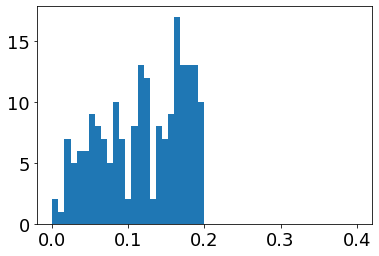

In [27]:
sample_numb = 200
random_index = np.random.RandomState(66).permutation(converg_latents_all_chains.shape[0])[:sample_numb]
sampled_latents_MCMC = converg_latents_all_chains[random_index]
sampled_dists_MCMC = converg_dists_all_chains[random_index]
print(sampled_latents_MCMC.shape)

plt.hist(sampled_dists_MCMC, bins = 50, range = (0, 0.4))



*Calculate facies models for the 200 randomly selected samples, and calculate the corresponding global features using the recognizer*


In [28]:
labels_run = np.zeros((sample_numb, 0, 4, 4))
wellfacies_run = np.zeros((sample_numb, 0, 64, 64)) 
prob_run = np.zeros((sample_numb, 0, 64, 64)) 

fakemodel_indicators = Gs_unc.run(sampled_latents_MCMC, labels_run, wellfacies_run, prob_run)
fakemodel_mcmc = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)  # [N, 1, 64, 64]

labels_mcmc_R = R.run(fakemodel_mcmc, wellfacies_run)[-1]
    
orit_one_hot_mcmc_R = labels_mcmc_R[:, :30]
orit_class_mcmc_R = np.argmax(orit_one_hot_mcmc_R, axis = 1)  #

mudprop_mcmc_R = labels_mcmc_R[:, 30] 
mudprop_mcmc_R = (mudprop_mcmc_R / 2 + 0.5) * 0.8037 + 0.1677

wid_mcmc_R = labels_mcmc_R[:, 31]  # width after normalization
wid_mcmc_R = np.where(wid_mcmc_R < -0.5, -1, np.where(wid_mcmc_R > 0.5, 1, 0)) 
wid_mcmc_R = (wid_mcmc_R / 2 + 0.5) * 8 + 27

wvl_mcmc_R = labels_mcmc_R[:, 32]  # width after normalization
wvl_mcmc_R = np.where(wvl_mcmc_R < -0.5, -1, np.where(wvl_mcmc_R < 0., -0.33, np.where(wvl_mcmc_R > 0.5, 1, 0.3))) 
wvl_mcmc_R = np.round((wvl_mcmc_R / 2 + 0.5) * 63 + 100)

amplt_mcmc_R = labels_mcmc_R[:, 33] 
amplt_mcmc_R = (amplt_mcmc_R / 2 + 0.5) * 104 + 7




*Visualize the facies models conditioned to the given global features and the pdf of their global features*


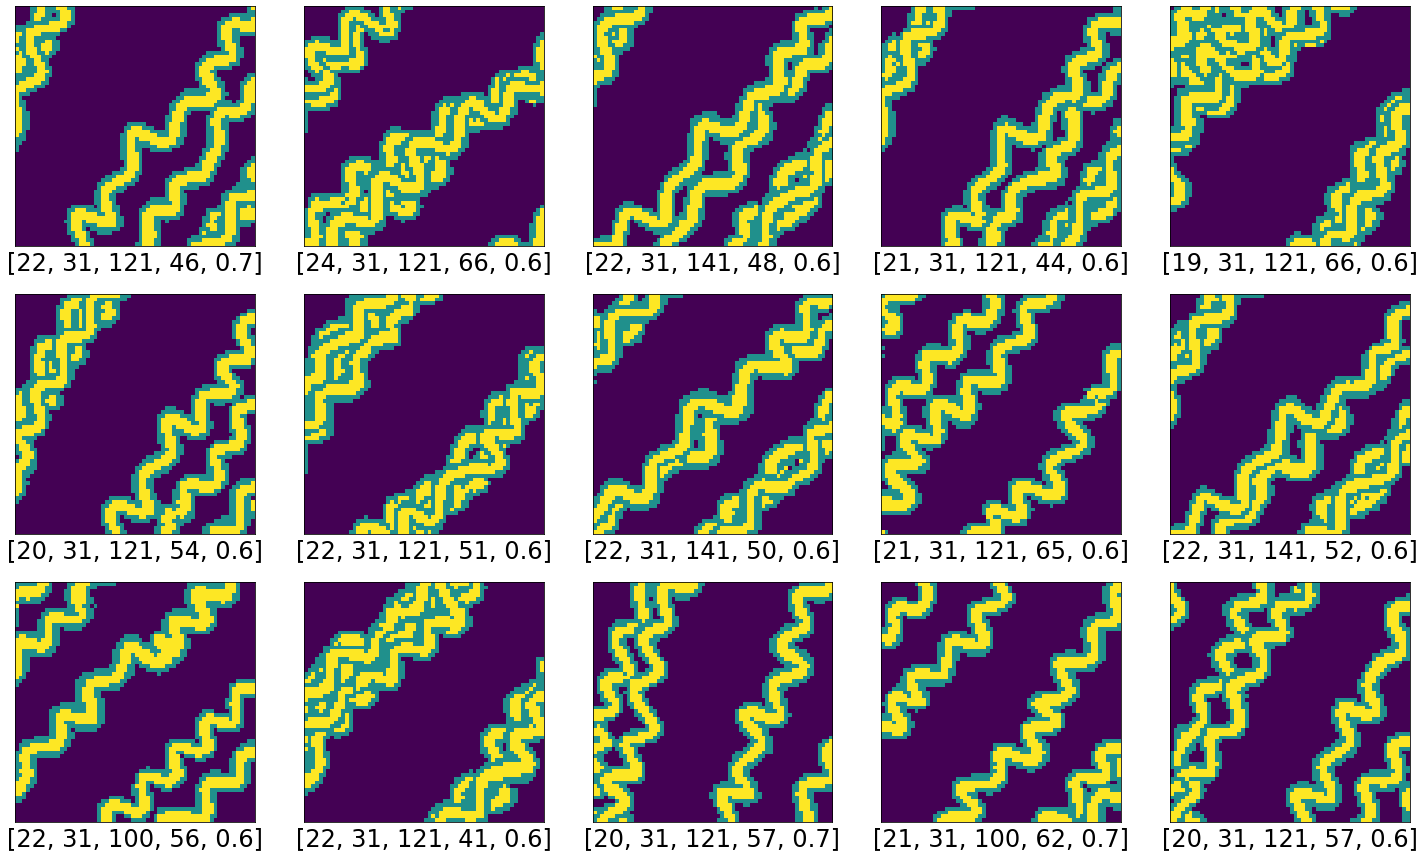

In [29]:
plt.rcParams.update({'font.size': 24})

def feature_str(idx):
    return f'{orit_class_mcmc_R[idx]}, {wid_mcmc_R[idx]:.0f}, {wvl_mcmc_R[idx]:.0f}, {amplt_mcmc_R[idx]:.0f}, {mudprop_mcmc_R[idx]:.1f}'

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    idx = j + 5
    ax[0, j].imshow(fakemodel_mcmc[idx, 0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{feature_str(idx)}]')
    ax[0, j].set_yticks([])

for j in range(5):
    idx = j + 15
    ax[1, j].imshow(fakemodel_mcmc[idx, 0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{feature_str(idx)}]')
    ax[1, j].set_yticks([])

for j in range(5):
    idx = j + 25
    ax[2, j].imshow(fakemodel_mcmc[idx, 0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{feature_str(idx)}]')
    ax[2, j].set_xticks([])
    ax[2, j].set_yticks([])

# Save if needed
# plt.savefig(mcmc_dir + "MCMC_10chain_thrshp015_random_15FaciesMaps_wGlobalFeatures.jpg", dpi=200)

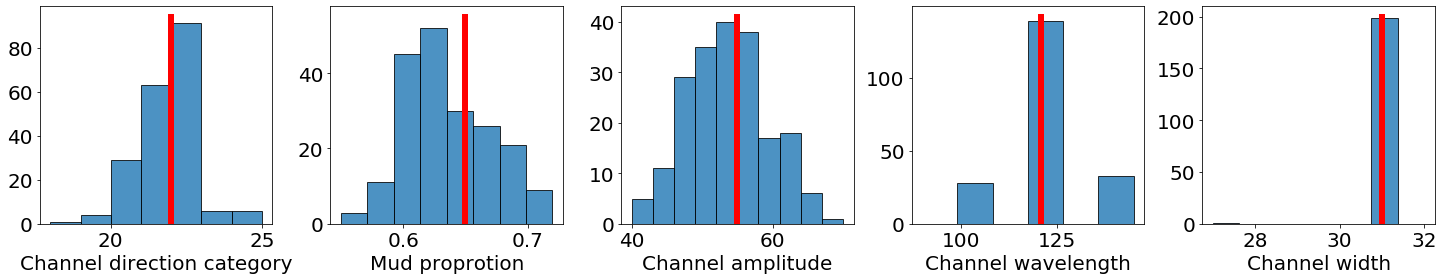

In [30]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 4)

# Plot the histogram with probability density
ax[0].hist(orit_class_mcmc_R, bins=7, range = (18, 25), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[0].plot([22, 22], [0, 94], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[0].set_xlabel(f'Channel direction category')

# Plot the histogram with probability density
ax[1].hist(mudprop_mcmc_R, bins=8, range = (0.55, 0.72), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[1].plot([0.65, 0.65], [0, 55], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[1].set_xlabel(f'Mud proprotion')

ax[2].hist(amplt_mcmc_R, bins=10, range = (40, 70), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[2].plot([55, 55], [0, 41], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[2].set_xlabel(f'Channel amplitude')

ax[3].hist(wvl_mcmc_R, bins=6, range = (90, 145), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[3].plot([121, 121], [0, 142], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[3].set_xlabel(f'Channel wavelength')

ax[4].hist(wid_mcmc_R, bins=8, range = (27, 32), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[4].plot([31, 31], [0, 200], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[4].set_xlabel(f'Channel width')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)  # Increase this value for more space

#plt.savefig(recognizer_dir + "MCMC_10chain_thrshp2_Geometrical histograms.jpg", dpi=200)   